# Deploying a SciKit-Learn Model with Azure ML

Create and attach the following Databricks PyPi libraries ***in this order***:
1. psutil
2. cryptography==1.5
3. pyopenssl==16.0.0
4. ipython==2.2.0
5. azureml-sdk[databricks]

In [2]:
# Helper function   
def load_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    # iterate through the folder tree
    for root, dirs, filenames in os.walk(folder):
        for d in dirs:
            print("Loading %s ..." % d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Read the image file
                imgFile = os.path.join(root,d, f)
                img = Image.open(imgFile)
                # Add the image to the features as a flattened numpy array
                features.append(np.array(img).ravel())
                # add the image class to the labels
                labels = np.append(labels, class_id)
            # Next class
            class_id = class_id + 1
    # Convert the features list to a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# Load the image data
data_folder = "/dbfs/resized_images"
features, labels, classnames = load_data(data_folder)
print("Loaded", len(features), "images of", len(classnames), "classes.")

Loading axes ...
Loading boots ...
Loading carabiners ...
Loading crampons ...
Loading gloves ...
Loading hardshell_jackets ...
Loading harnesses ...
Loading helmets ...
Loading insulated_jackets ...
Loading pulleys ...
Loading rope ...
Loading tents ...
Loaded 2122 images of 12 classes.

In [3]:
# split the image data into training and testing sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30)

print(x_train.shape)
print(y_train.shape)

(1485, 49152)
(1485,)

In [4]:
# Train a classifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Create a pipeline (in case we want to add transformations later)
img_pipeline = Pipeline([('classify', RandomForestClassifier()),
                        ])
# Use the pipeline to fit a model to the training data
print("Training model...")
image_classifier = img_pipeline.fit(x_train, y_train)

print('classifier trained!')

/databricks/python/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
 from numpy.core.umath_tests import inner1d
Training model...
classifier trained!

In [5]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import numpy as np

print('Calculating classifier metrics...')
predictions = image_classifier.predict(x_test)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy:' + str(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
print(cm)

Calculating classifier metrics...
 precision recall f1-score support

 axes 0.78 0.91 0.84 23
 boots 0.85 0.95 0.90 37
 carabiners 0.90 0.96 0.93 67
 crampons 0.86 0.74 0.79 42
 gloves 0.88 0.84 0.86 69
hardshell_jackets 0.75 0.90 0.82 135
 harnesses 0.95 0.93 0.94 60
 helmets 0.77 0.96 0.86 25
insulated_jackets 0.71 0.43 0.54 67
 pulleys 1.00 0.31 0.47 13
 rope 0.95 0.88 0.91 67
 tents 0.86 1.00 0.93 32

 avg / total 0.84 0.84 0.83 637

Accuracy:0.8398744113029827

 Confusion Matrix:
[[ 21 0 0 1 0 0 1 0 0 0 0 0]
 [ 0 35 0 0 1 0 1 0 0 0 0 0]
 [ 1 1 64 1 0 0 0 0 0 0 0 0]
 [ 5 1 4 31 0 0 0 1 0 0 0 0]
 [ 0 1 2 0 58 1 1 1 2 0 3 0]
 [ 0 0 1 0 3 122 0 0 9 0 0 0]
 [ 0 2 0 1 1 0 56 0 0 0 0 0]
 [ 0 0 0 0 1 0 0 24 0 0 0 0]
 [ 0 0 0 0 1 36 0 0 29 0 0 1]
 [ 0 0 0 0 1 3 0 5 0 4 0 0]
 [ 0 1 0 2 0 0 0 0 1 0 59 4]
 [ 0 0 0 0 0 0 0 0 0 0 0 32]]

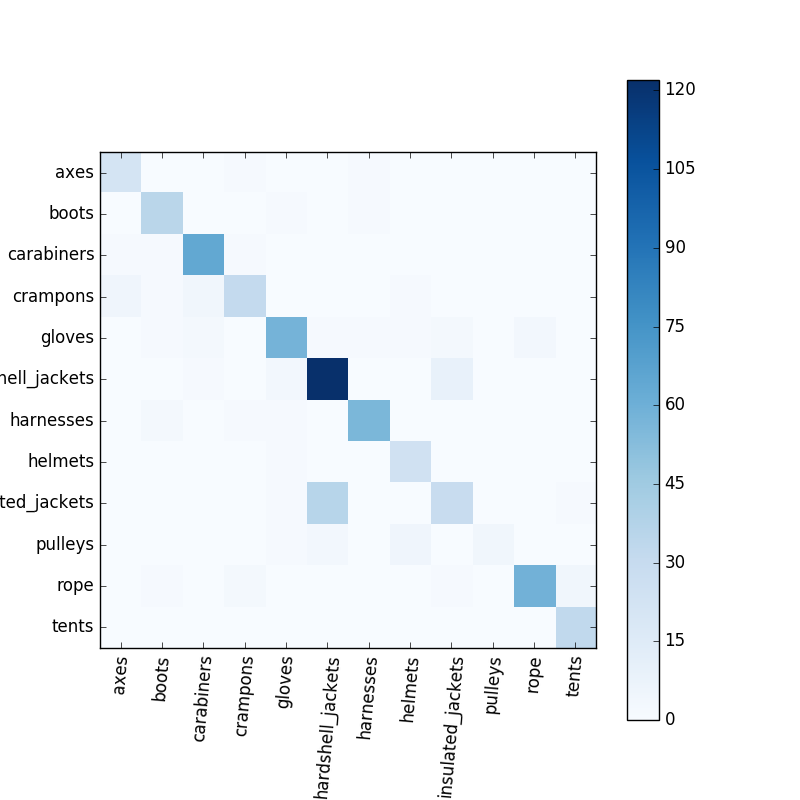

In [6]:
# Plot confusion matrix as heatmap
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
display(fig)

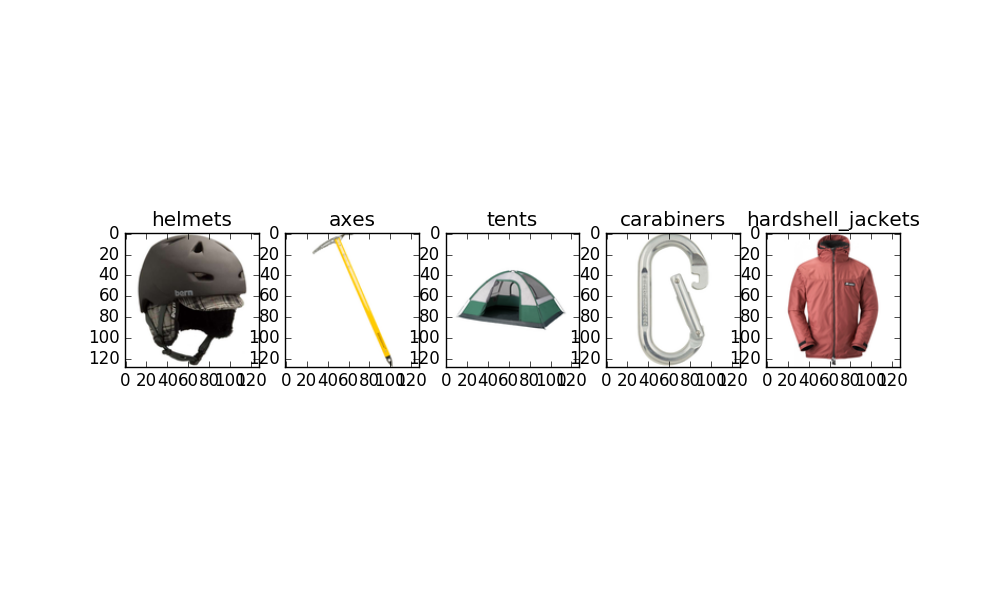

In [7]:
# function to resize new images to match training data
def resize_image(img, size=(128,128)):
    from PIL import Image
    import numpy as np
    
    # Create a white image of the target size
    newimg = Image.new("RGB", size, (255, 255, 255))
        
    # resize the source image (if not square, this will scale largest dimension to size)
    img.thumbnail(size, Image.ANTIALIAS)
    
    # paste the resized source image into the middle of the target image
    newimg.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)))
    
    return newimg


# Predict class for new data
from PIL import Image, ImageOps
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

image_urls = []
image_urls.append('https://i.stack.imgur.com/5I4Rx.jpg')
image_urls.append('https://i.stack.imgur.com/HeliW.jpg')
image_urls.append('https://productimages.camping-gear-outlet.com/e5/62379.jpg')
image_urls.append('http://s7d1.scene7.com/is/image/MoosejawMB/MIKAJMKFMKCAPNABx1024698_zm?$product1000$')
image_urls.append('http://www.buffalosystems.co.uk/wp-content/uploads/2012/06/zoom_apline_jacket_dark_russet-2365x3286.jpg')

fig = plt.figure(figsize=(10, 6))

# Get the images and show the predicted classes
for url_idx in range(len(image_urls)):
    response = requests.get(image_urls[url_idx])
    img = Image.open(BytesIO(response.content))
    
    #pre-process the image so it matches the training set
    img = resize_image(img, (128,128))

    # Flatten the image data to correct feature format
    imgfeatures = np.array(img).ravel().reshape(1, -1)
    
    # predict the class for the new image
    class_idx =  image_classifier.predict(imgfeatures)
    class_name = classnames[int(class_idx)]
    a=fig.add_subplot(1,len(image_urls),url_idx+1)
    imgplot = plt.imshow(img)
    a.set_title(class_name)
display(fig)

In [8]:
# Save the model
import pickle

pickle.dump(image_classifier, open('adventureworks-sk.pkl', 'wb'))
print("Model saved.")

Model saved.

In [9]:
# Check installed Azure ML version

import azureml.core
print(azureml.core.VERSION)

0.1.80

In [10]:
# Create an Azure ML workspace
from azureml.core import Workspace
ws = Workspace.create(name='adventureworks-ml',
                      subscription_id='YOUR_AZURE_SUBSCRIPTION_ID',
                      resource_group='openhack',
                      create_resource_group=True,
                      location='eastus2' # or other supported Azure region
                     )

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code AHBDU2MNX to authenticate.
Interactive authentication successfully completed.

In [11]:
# Save the workspace config so we can load it again in later sessions
ws.write_config()

# Test loading it
from azureml.core import Workspace
ws = Workspace.from_config()

Wrote the config file config.json to: /databricks/driver/aml_config/config.json
Found the config file in: /databricks/driver/aml_config/config.json

In [12]:
%%writefile score.py

# create a scoring script that loads and infers from the model
import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from azureml.core.model import Model

def init():
    global model
    # retreive the local path to the model using the model name
    model_path = Model.get_model_path('adventureworks-sk.pkl')
    model = joblib.load(model_path)
    
def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    return json.dumps(y_hat.tolist())

Writing score.py

In [13]:
from azureml.core.conda_dependencies import CondaDependencies 

# Create a .yml config file to install dependencies in the container
myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())
    
print("Conda Dependencies file created.")

Conda Dependencies file created.

In [14]:
from azureml.core.image import ContainerImage

# Define a container image that uses the score and dependencies files
image_config = ContainerImage.image_configuration(execution_script = "score.py",
                                                  runtime = "python",
                                                  conda_file = "myenv.yml",
                                                  description = "Adventure Works scikit-learn classifier",
                                                  tags = {"data": "Adventure Works gear", "type": "classification"}
                                                 )
print("Container image defined.")

Container image defined.

In [15]:
from azureml.core.webservice import AciWebservice

# Define the service configuration
aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {"data": "Adventure Works gear", "type": "classification"},
                                               description = 'Adventure Works scikit-learn classifier')

print("Service config defined.")

Service config defined.

In [16]:
from azureml.core.webservice import Webservice

# Deploy the container as a service named aw-sk-svc, registering the locally saved model
service_name = 'aw-sk-svc'
service = Webservice.deploy(deployment_config = aciconfig,
                                image_config = image_config,
                                model_paths = ['adventureworks-sk.pkl'],
                                name = service_name,
                                workspace = ws)

service.wait_for_deployment(show_output = True)
print(service.state)

Registering model adventureworks-sk.pkl
Creating image
Image creation operation finished for image aw-sk-svc:2, operation "Succeeded"
Creating service
Running..................................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy

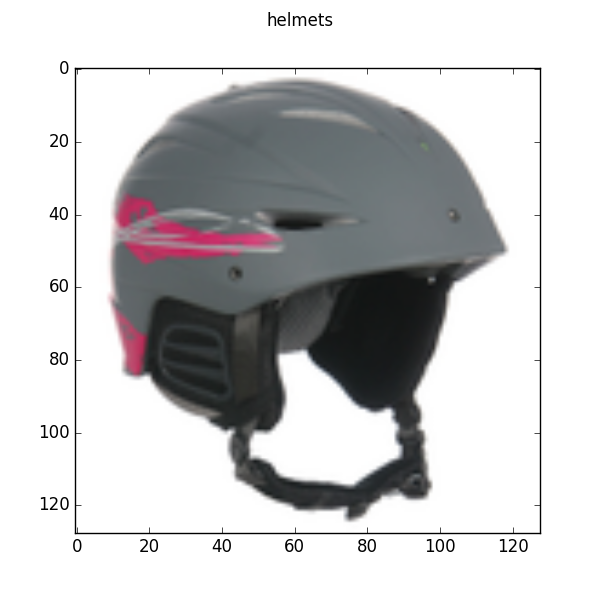

In [17]:
import json
from random import randint
from PIL import Image, ImageOps

# Create a test image
img_url = "http://images.the-house.com/giro-g10mx-mtgy-07.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))

#pre-process the image so it matches the training set
img = resize_image(img, (128,128))

# Get the image features as an array of (one) images
imgfeatures = np.array(img).ravel().reshape(1, -1)

# Create the request JSON and package it as bytes
test_sample = json.dumps({"data": imgfeatures.tolist()})
test_sample = bytes(test_sample, encoding = 'utf8')

# Call the service to get the predicted class
prediction = service.run(input_data = test_sample)
classid = np.array(json.loads(prediction))[0]

# Print the results (and the image)
classname = classnames[int(classid)]
fig = plt.figure(figsize=(6,6))
plt.imshow(img)
fig.suptitle(classname)
display(fig)


In [18]:
# Delete the service when finished with it
service.delete()